# Bài 1: Lọc trung bình 7x7 cho ảnh salesman.bin

Áp dụng 3 phương pháp:
1. Convolution trực tiếp trong miền ảnh với zero-padding.
2. Lọc bằng DFT 2D với zero-padded impulse response (128x128).
3. Lọc bằng DFT 2D với zero-phase impulse response (256x256).

Mục tiêu: tất cả kết quả giống nhau.


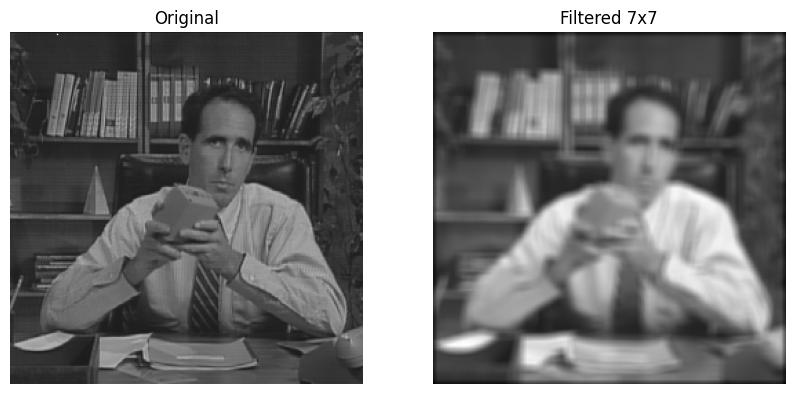

In [2]:
# Bài 1(a): Convolution trực tiếp trong miền ảnh
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Hàm stretch ảnh full-scale
def stretch(img):
    img_min, img_max = img.min(), img.max()
    return np.round((img - img_min) * 255.0 / (img_max - img_min)).astype(np.uint8)

# Đọc ảnh raw 256x256
X = np.fromfile('salesman.bin', dtype=np.uint8).reshape((256,256))

# Zero-padding 3 pixel mỗi cạnh
X_pad = np.pad(X, pad_width=3, mode='constant', constant_values=0)

# Khởi tạo output
Y = np.zeros_like(X_pad, dtype=float)

# Lọc trung bình 7x7
kernel_size = 7
for i in range(3, 259):
    for j in range(3, 259):
        Y[i,j] = X_pad[i-3:i+4, j-3:j+4].sum() / 49

# Crop về kích thước gốc và stretch
Y1a = stretch(Y[3:259, 3:259])

# Hiển thị ảnh
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(X, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(Y1a, cmap='gray'); plt.title('Filtered 7x7'); plt.axis('off')
plt.show()


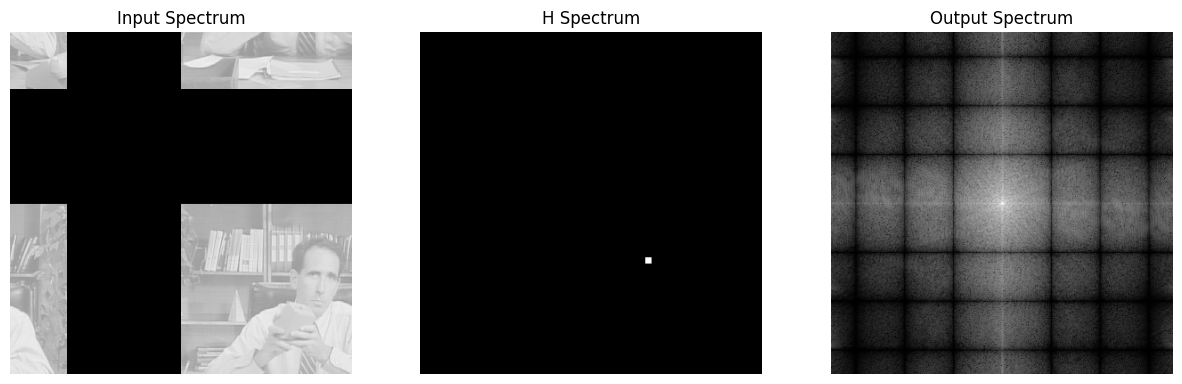

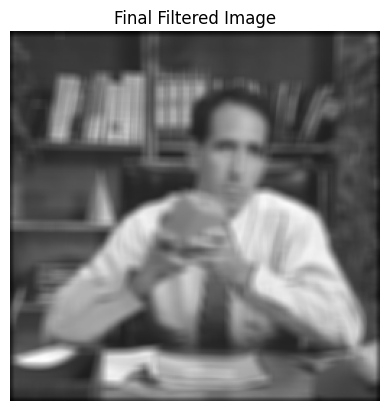

Max difference with part (a): 0


In [3]:
# Bài 1(b): DFT với zero-padded impulse response 128x128
# (Pointwise multiplication)
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

# Zero-pad ảnh 256x256 và H 128x128 -> tổng 384x384
pad_size = 256 + 128
ZPX = np.zeros((pad_size, pad_size))
ZPX[:256,:256] = X

H = np.zeros((128,128))
H[61:68,61:68] = 1/49  # center 7x7 square
ZPH = np.zeros((pad_size,pad_size))
ZPH[:128,:128] = H

# FFT
ZPX_tilde = fft2(ZPX)
ZPH_tilde = fft2(ZPH)

# Log-magnitude spectrum
def log_spectrum(X):
    return np.log(1 + np.abs(fftshift(X)))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(stretch(log_spectrum(ZPX)), cmap='gray'); plt.title('Input Spectrum'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(stretch(log_spectrum(ZPH)), cmap='gray'); plt.title('H Spectrum'); plt.axis('off')

# Convolution bằng pointwise multiplication
ZPY = ifft2(ZPX_tilde * ZPH_tilde).real
plt.subplot(1,3,3); plt.imshow(stretch(log_spectrum(ZPX_tilde*ZPH_tilde)), cmap='gray'); plt.title('Output Spectrum'); plt.axis('off')
plt.show()

# Crop về 256x256 cuối cùng
Y1b = stretch(ZPY[64:320,64:320])
plt.imshow(Y1b, cmap='gray'); plt.title('Final Filtered Image'); plt.axis('off'); plt.show()
print("Max difference with part (a):", np.max(np.abs(Y1a-Y1b)))


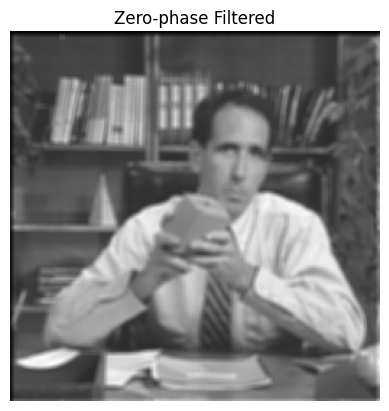

Max difference with part (a): 255


In [4]:
# Bài 1(c): DFT với zero-phase impulse response 256x256
# (Tương tự Example 5)
pad_size = 512
ZPX = np.zeros((pad_size,pad_size))
ZPX[:256,:256] = X

H = np.zeros((256,256))
H[125:132,125:132] = 1/49  # 7x7 center

# fftshift để zero-phase
H2 = fftshift(H)

# Zero pad H2
ZPH2 = np.zeros((pad_size,pad_size))
ZPH2[:256,:256] = H2

# FFT và pointwise multiply
ZPY = ifft2(fft2(ZPX) * fft2(ZPH2)).real

# Crop về 256x256 cuối cùng và stretch
Y1c = stretch(ZPY[:256,:256])
plt.imshow(Y1c, cmap='gray'); plt.title('Zero-phase Filtered'); plt.axis('off'); plt.show()
print("Max difference with part (a):", np.max(np.abs(Y1a-Y1c)))


# Bài 2: Lọc ảnh Tiffany (girl2.bin) với nhiễu

1. Đọc ảnh gốc và hai ảnh nhiễu.
2. Tính MSE giữa các ảnh nhiễu và ảnh gốc.
3. Áp dụng Ideal LPF (U_cutoff=64), Gaussian LPF (U_cutoff=64) và Gaussian LPF (U_cutoff=77.5).
4. Tính ISNR cho ảnh nhiễu.


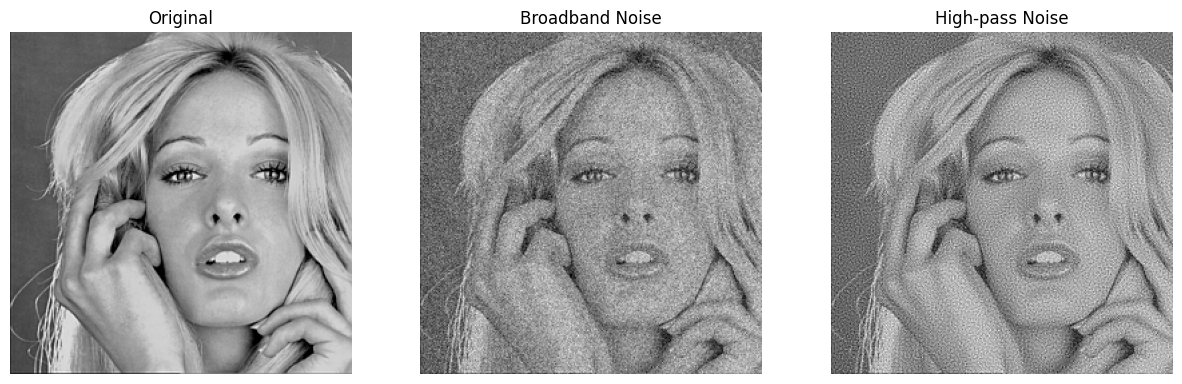

MSE Noise32: 744.4679107666016
MSE Noise32Hi: 692.5050201416016


In [5]:
# Bài 2(a): Đọc ảnh và tính MSE
def mse(img1,img2):
    return np.mean((img1.astype(float)-img2.astype(float))**2)

X = np.fromfile('girl2.bin', dtype=np.uint8).reshape((256,256))
XN = np.fromfile('girl2Noise32.bin', dtype=np.uint8).reshape((256,256))
XNhi = np.fromfile('girl2Noise32Hi.bin', dtype=np.uint8).reshape((256,256))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(X, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(XN, cmap='gray'); plt.title('Broadband Noise'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(XNhi, cmap='gray'); plt.title('High-pass Noise'); plt.axis('off')
plt.show()

print("MSE Noise32:", mse(X,XN))
print("MSE Noise32Hi:", mse(X,XNhi))


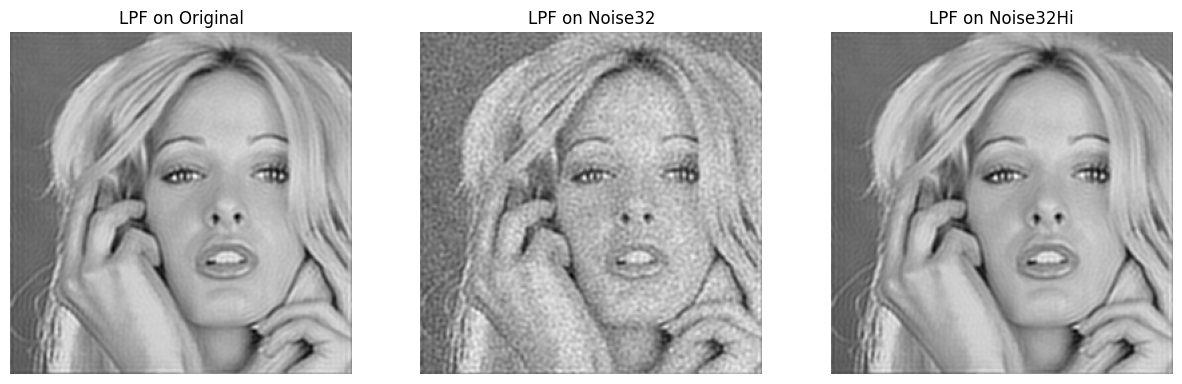

MSE LPF Original: 127.7480831198165
MSE LPF Noise32: 550.8786914157856 ISNR: -7.548655329151717
MSE LPF Noise32Hi: 398.99781881247645 ISNR: -6.22688600509425


In [6]:
# Bài 2(b): Ideal LPF
from numpy.fft import fft2, ifft2, fftshift, ifftshift

U_cutoff = 64
u = np.arange(-128,128)
v = np.arange(-128,128)
U,V = np.meshgrid(u,v)
HLtildeCenter = ((U**2+V**2)<=U_cutoff**2).astype(float)
HLtilde = fftshift(HLtildeCenter)

def apply_filter(img,Htilde):
    return np.real(ifft2(fft2(img)*Htilde))

Y_orig = apply_filter(X,HLtilde)
Y_N = apply_filter(XN,HLtilde)
Y_Nhi = apply_filter(XNhi,HLtilde)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(stretch(Y_orig), cmap='gray'); plt.title('LPF on Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(stretch(Y_N), cmap='gray'); plt.title('LPF on Noise32'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(stretch(Y_Nhi), cmap='gray'); plt.title('LPF on Noise32Hi'); plt.axis('off')
plt.show()

def isnr(noisy, filtered, original):
    return 10*np.log10(np.mean((noisy-original)**2)/np.mean((filtered-original)**2))

print("MSE LPF Original:", mse(X,Y_orig))
print("MSE LPF Noise32:", mse(X,Y_N), "ISNR:", isnr(XN,Y_N,X))
print("MSE LPF Noise32Hi:", mse(X,Y_Nhi), "ISNR:", isnr(XNhi,Y_Nhi,X))


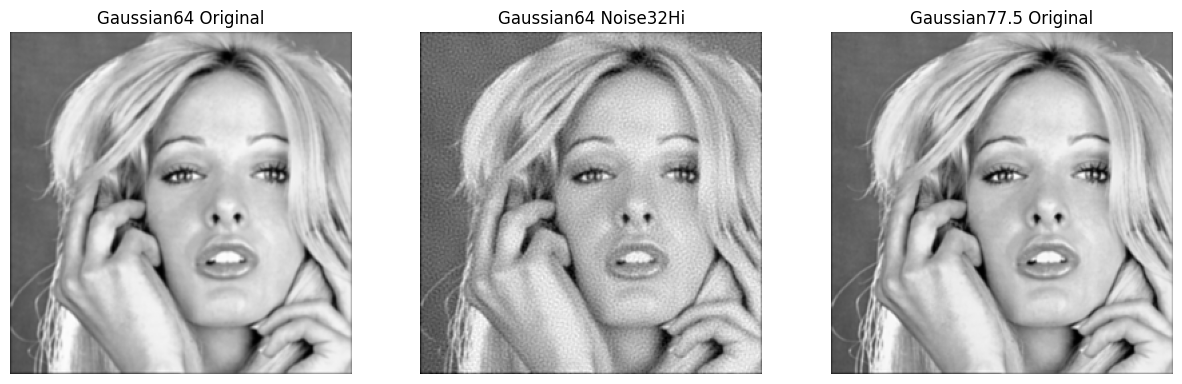

MSE Gaussian64 Original: 91.25848906704083 Noise32Hi ISNR: -6.406253974658735
MSE Gaussian77.5 Original: 60.618360263317975


In [7]:
# Bài 2(c,d): Gaussian LPF
def gaussian_lpf(img, U_cutoff):
    N = 256
    SigmaG = 0.19 * N / U_cutoff
    u = np.arange(-128,128)
    v = np.arange(-128,128)
    U,V = np.meshgrid(u,v)
    GtildeCenter = np.exp((-2*np.pi**2*SigmaG**2)/(N**2)*(U**2+V**2))
    Gtilde = fftshift(GtildeCenter)
    G = fftshift(np.real(ifft2(Gtilde)))
    ZPG2 = np.zeros((512,512))
    ZPG2[:256,:256] = G
    ZPX = np.zeros((512,512))
    ZPX[:256,:256] = img
    filtered = np.real(ifft2(fft2(ZPX)*fft2(ZPG2)))
    return filtered[128:384,128:384]

Y_G64 = gaussian_lpf(X,64)
Y_G64_N = gaussian_lpf(XN,64)
Y_G64_Nhi = gaussian_lpf(XNhi,64)

Y_G77 = gaussian_lpf(X,77.5)
Y_G77_N = gaussian_lpf(XN,77.5)
Y_G77_Nhi = gaussian_lpf(XNhi,77.5)

# Hiển thị một ví dụ
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(stretch(Y_G64), cmap='gray'); plt.title('Gaussian64 Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(stretch(Y_G64_Nhi), cmap='gray'); plt.title('Gaussian64 Noise32Hi'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(stretch(Y_G77), cmap='gray'); plt.title('Gaussian77.5 Original'); plt.axis('off')
plt.show()

print("MSE Gaussian64 Original:", mse(X,Y_G64), "Noise32Hi ISNR:", isnr(XNhi,Y_G64_Nhi,X))
print("MSE Gaussian77.5 Original:", mse(X,Y_G77))
